In [274]:
# Download from https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

import pandas as pd
import requests
import io

confirmedUrl = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
deathsUrl = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'

r = requests.post(confirmedUrl)
if r.ok:
    data = r.content.decode('utf8')
    df = pd.read_csv(io.StringIO(data))
    
# Rename Province/State and Country/Region
df = df.rename(columns={'Province/State': 'provincestate', 'Country/Region': 'countryregion'})

# Remove unneeded columns
df = df.drop(['Lat', 'Long', 'provincestate'], axis=1)

# Reshape 
df_confirmed = df.melt(var_name='date', value_name='confirmed', id_vars='countryregion')
df_confirmed['date'] = pd.to_datetime(df_confirmed['date'])

print('Retrieved results from {} to {}'.format(df_confirmed['date'].min(), df_confirmed['date'].max()))


Retrieved results from 2020-01-22 00:00:00 to 2020-03-16 00:00:00


In [275]:
### Group values
df_confirmed_grouped = df_confirmed[['date','countryregion', 'confirmed']].groupby(['date', 'countryregion']).sum()

print(df_confirmed_grouped)

                                           confirmed
date       countryregion                            
2020-01-22 Afghanistan                             0
           Albania                                 0
           Algeria                                 0
           Andorra                                 0
           Antigua and Barbuda                     0
...                                              ...
2020-03-16 Uruguay                                 8
           Uzbekistan                              6
           Venezuela                              17
           Vietnam                                61
           occupied Palestinian territory          0

[8580 rows x 1 columns]


In [276]:
# # Sort by day by country
# df_confirmed_grouped.sort_values('confirmed').head(50)

In [277]:
# Prepare China
df_china = df_confirmed_grouped.query('countryregion == "China"')
df_china_prepared = df_china.droplevel('countryregion').rename(columns=lambda x: x+' (china)').reset_index().melt(id_vars="date")

df_china_prepared.head(10)

,date,variable,value
0,2020-01-22,confirmed (china),548
1,2020-01-23,confirmed (china),643
2,2020-01-24,confirmed (china),920
3,2020-01-25,confirmed (china),1406
4,2020-01-26,confirmed (china),2075
5,2020-01-27,confirmed (china),2877
6,2020-01-28,confirmed (china),5509
7,2020-01-29,confirmed (china),6087
8,2020-01-30,confirmed (china),8141
9,2020-01-31,confirmed (china),9802


In [302]:
# Prepare non-China
# print(df_confirmed_grouped.index.unique(level='countryregion'))
df_non_china = df_confirmed_grouped.query('countryregion != "China"')
df_non_china_prepared = df_non_china.sum(level='date').fillna(0).rename(columns=lambda x: x+' (non-china)').reset_index().melt(id_vars="date")
df_non_china_prepared.head(10)

,date,variable,value
0,2020-01-22,confirmed (non-china),1
1,2020-01-23,confirmed (non-china),1
2,2020-01-24,confirmed (non-china),2
3,2020-01-25,confirmed (non-china),2
4,2020-01-26,confirmed (non-china),5
5,2020-01-27,confirmed (non-china),5
6,2020-01-28,confirmed (non-china),5
7,2020-01-29,confirmed (non-china),5
8,2020-01-30,confirmed (non-china),5
9,2020-01-31,confirmed (non-china),7


In [303]:
# Calculate percentage change
window = 5
growthCalculation = lambda x: (x.max())

from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()

x = pd.Series(range(0,window)).values.reshape(-1,1)
linearCoefficient = lambda values: (linear_regressor.fit(x, values.values.reshape(-1,1)).coef_)

df_china_prepared['growth_rate'] = df_china_prepared.groupby(['variable'])['value'].rolling(window).apply(linearCoefficient).fillna(0).reset_index(level=0, drop=True)
df_china_prepared['acceleration_rate'] = df_china_prepared['growth_rate'].rolling(window).apply(linearCoefficient).fillna(0).reset_index(level=0, drop=True)

df_non_china_prepared['growth_rate'] = df_non_china_prepared.groupby(['variable'])['value'].rolling(window).apply(linearCoefficient).fillna(0).reset_index(level=0, drop=True)
df_non_china_prepared['acceleration_rate'] = df_non_china_prepared['growth_rate'].rolling(window).apply(linearCoefficient).fillna(0).reset_index(level=0, drop=True)



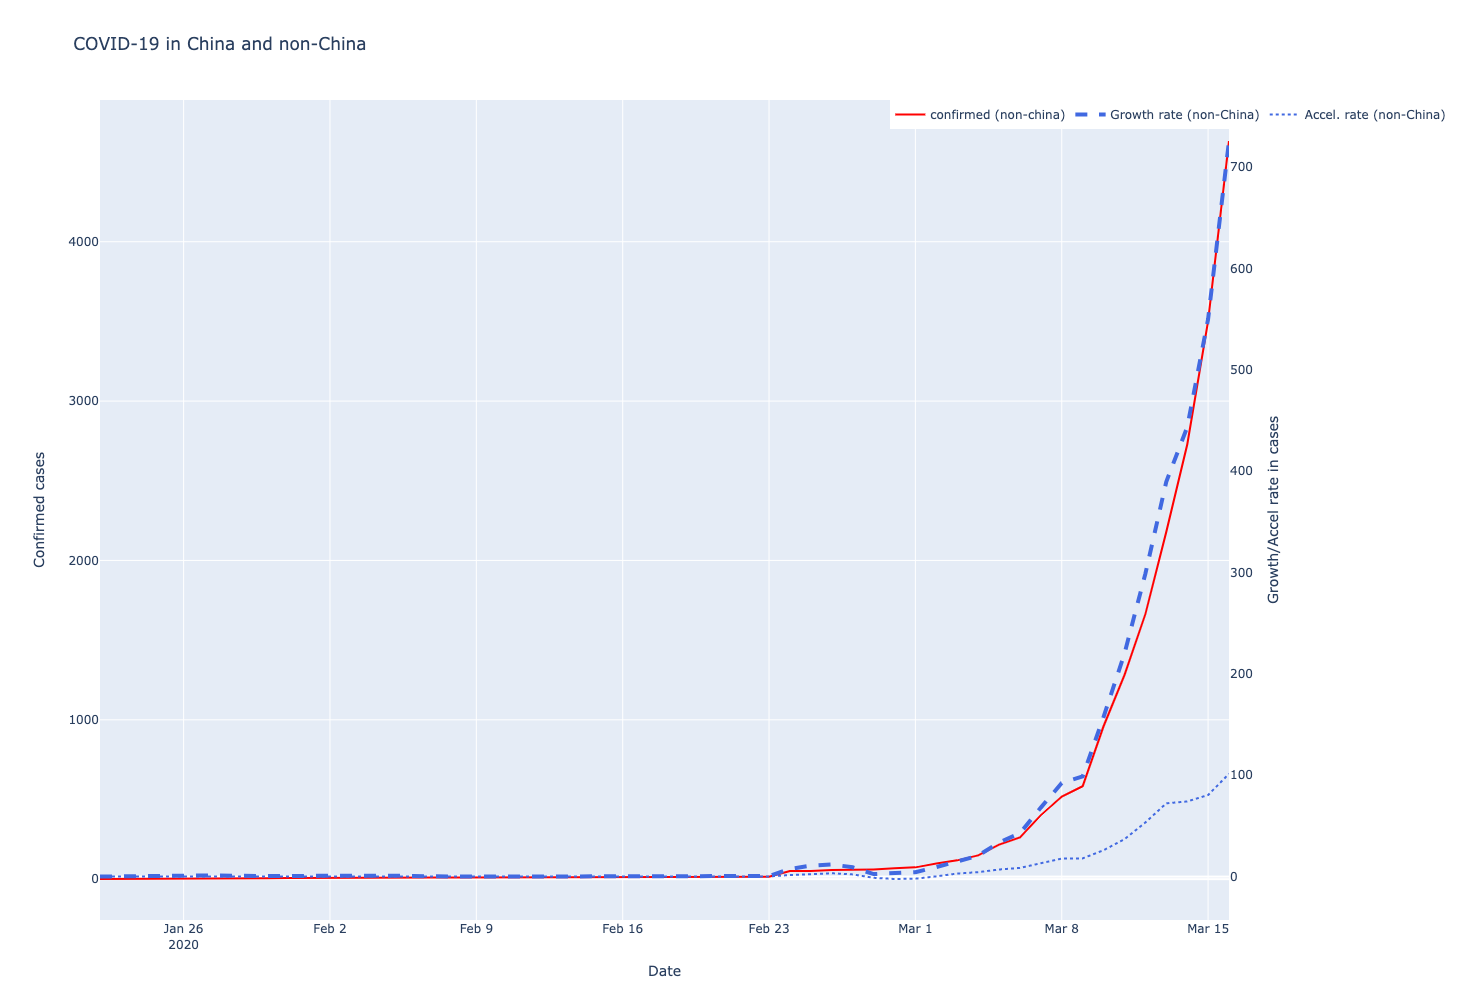

In [305]:
# Show fig
import plotly.express as px
import plotly.graph_objects as go

colorSequence = ["red", "royalblue"]

layout = go.Layout(title="COVID-19 in China and non-China", margin={"l": 100, "r": 100},
                   colorway=["#287D95", "#EF533B"], legend={"x": 0.7, "y": 1, 'orientation': "h"},
                   yaxis={'title': 'Confirmed cases'},
                   yaxis2={'title': 'Growth/Accel rate in cases', 'overlaying': 'y', 'side': 'right', "showgrid": False},
                   xaxis={"title": "Date"},
                   height=1000)

chinaColor = colorSequence[0]
nonChinaColor = colorSequence[1]

traces_confirmed = px.line(pd.concat([df_china_prepared, df_non_china_prepared]), 
                           x='date', 
                           y='value', 
                           color='variable', 
                           title='COVID-19 in China and non-China',
                           color_discrete_sequence=colorSequence,).data

# Add growth rate
trace_growth_china = go.Scatter(x=df_china_prepared['date'], 
                                y=df_china_prepared['growth_rate'], 
                                name='Growth rate (China)',
                                line=dict(color=chinaColor, 
                                          width=4, 
                                          dash='dash'), 
                                yaxis="y2")
trace_growth_non_china = go.Scatter(x=df_non_china_prepared['date'], 
                                    y=df_non_china_prepared['growth_rate'], 
                                    name='Growth rate (non-China)',
                                    line=dict(color=nonChinaColor, 
                                              width=4, 
                                              dash='dash'), 
                                    yaxis="y2")

# Add acceleration rate
trace_accel_china = go.Scatter(x=df_china_prepared['date'], 
                               y=df_china_prepared['acceleration_rate'], 
                               name='Accel. rate (China)',
                         line=dict(color=chinaColor, 
                                   width=2, 
                                   dash='dot'), 
                               yaxis="y2")
trace_accel_non_china = go.Scatter(x=df_non_china_prepared['date'], 
                                   y=df_non_china_prepared['acceleration_rate'], 
                                   name='Accel. rate (non-China)',
                         line=dict(color=nonChinaColor, 
                                   width=2, 
                                   dash='dot'), 
                                   yaxis="y2")

# Combine to make a tuple
traces_combined = traces_confirmed + (trace_growth_china, trace_accel_china, trace_growth_non_china, trace_accel_non_china,)
fig = go.Figure(data=traces_combined, layout=layout)
fig.show()